## Setup

In [36]:
!pip install kaggle
!pip install opendatasets
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install nltk
!pip install seaborn

In [ ]:
import opendatasets as od
 
od.download("https://www.kaggle.com/datasets/stackoverflow/stacksample/")


In [1]:
import pandas as pd
from io import StringIO

In [2]:
# Importing the Questions.csv file

questions_df = pd.read_csv('stacksample/Questions.csv', encoding = "ISO-8859-1")
questions_df.head()

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body
0,80,26.0,2008-08-01T13:57:07Z,NaN,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...
1,90,58.0,2008-08-01T14:41:24Z,2012-12-26T03:45:49Z,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...
2,120,83.0,2008-08-01T15:50:08Z,NaN,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...
3,180,2089740.0,2008-08-01T18:42:19Z,NaN,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...
4,260,91.0,2008-08-01T23:22:08Z,NaN,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...


In [3]:
# Importing the Answers.csv file

answers_df = pd.read_csv('stacksample/Answers.csv', encoding = "ISO-8859-1")
answers_df.head()

,Id,OwnerUserId,CreationDate,ParentId,Score,Body
0,92,61.0,2008-08-01T14:45:37Z,90,13,"<p><a href=""http://svnbook.red-bean.com/"">Vers..."
1,124,26.0,2008-08-01T16:09:47Z,80,12,<p>I wound up using this. It is a kind of a ha...
2,199,50.0,2008-08-01T19:36:46Z,180,1,<p>I've read somewhere the human eye can't dis...
3,269,91.0,2008-08-01T23:49:57Z,260,4,"<p>Yes, I thought about that, but I soon figur..."
4,307,49.0,2008-08-02T01:49:46Z,260,28,"<p><a href=""http://www.codeproject.com/Article..."


In [ ]:
# Removing the Tags.csv file beacuse we don't need it
import os

os.remove("stacksample/Tags.csv")

## Data preprocessing

In [4]:
## Grouping answers by ParentId and calculating the sum of scores from Answers
total_answers_score = answers_df.groupby('ParentId')['Score'].sum().reset_index()
total_answers_score.rename(columns={'Score': 'TotalAnswersScore', 'ParentId': 'Id'}, inplace=True)

merged_df = questions_df.merge(total_answers_score, on='Id', how='left')

merged_df['TotalAnswersScore'] = merged_df['TotalAnswersScore'].fillna(0)

merged_df['Closed'] = merged_df['ClosedDate'].notnull()

columns_to_remove = ['OwnerUserId', 'CreationDate', 'ClosedDate']
merged_df = merged_df.drop(columns=columns_to_remove)

# Saving the merged data to a new CSV file
prosessed_file_path = './Questions_with_TotalAnswersScore.csv'
merged_df.to_csv(prosessed_file_path, index=False)

### Clean Ram

In [ ]:
import gc 
gc.collect()
del questions_df
del answers_df
del merged_df

### Read procesed data

In [2]:
# Run if you have already downloaded the dataset and processed it

import pandas as pd
from io import StringIO

prosessed_file_path = './Questions_with_TotalAnswersScore.csv'

In [3]:
import pandas as pd
from io import StringIO

modified_qustions_df = pd.read_csv(prosessed_file_path, encoding = "ISO-8859-1")
modified_qustions_df.head()

,Id,Score,Title,Body,TotalAnswersScore,Closed
0,80,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,19.0,False
1,90,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,34.0,True
2,120,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,9.0,False
3,180,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,54.0,False
4,260,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,63.0,False


# Data analysis

In [8]:
import os
import matplotlib.pyplot as plt

data_analysis_path = './data_analysis/'
if not os.path.exists(data_analysis_path):
    os.makedirs(data_analysis_path)


### Statistics of length of questions title and body

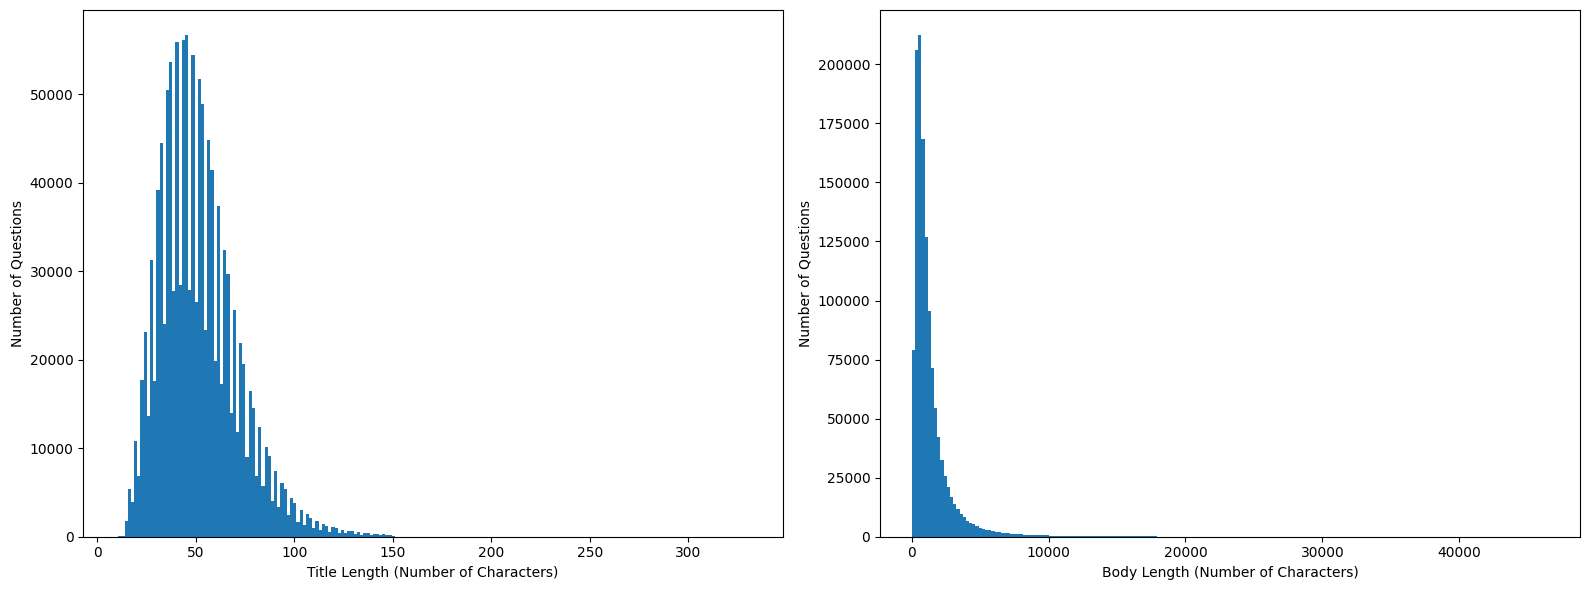

Title mean characters count: 51.740
Title median characters count: 49.000

Body mean characters count: 1411.782
Body median characters count: 895.000


In [23]:
# calculating lenght of title and body
modified_qustions_df['TitleLength'] = modified_qustions_df['Title'].str.len()
modified_qustions_df['BodyLength'] = modified_qustions_df['Body'].str.len()

# plotting the distribution of TitleLength and BodyLength
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.hist(modified_qustions_df['TitleLength'], bins=200)
plt.xlabel('Title Length (Number of Characters)')
plt.ylabel('Number of Questions')

plt.subplot(1, 2, 2)
plt.hist(modified_qustions_df['BodyLength'], bins=200)
plt.xlabel('Body Length (Number of Characters)')
plt.ylabel('Number of Questions')

plt.tight_layout()

plt.savefig(data_analysis_path + 'title_body_length_distribution.png', dpi=300)
plt.show()

# printing the mean and median of TitleLength and BodyLength
print('Title mean characters count: {:.3f}'.format(modified_qustions_df['TitleLength'].mean()))
print('Title median characters count: {}'.format(modified_qustions_df['TitleLength'].median()))
print('')
print('Body mean characters count: {:.3f}'.format(modified_qustions_df['BodyLength'].mean()))
print('Body median characters count: {}'.format(modified_qustions_df['BodyLength'].median()))

### Statistics words count of questions title and body

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kijada\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\kijada\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


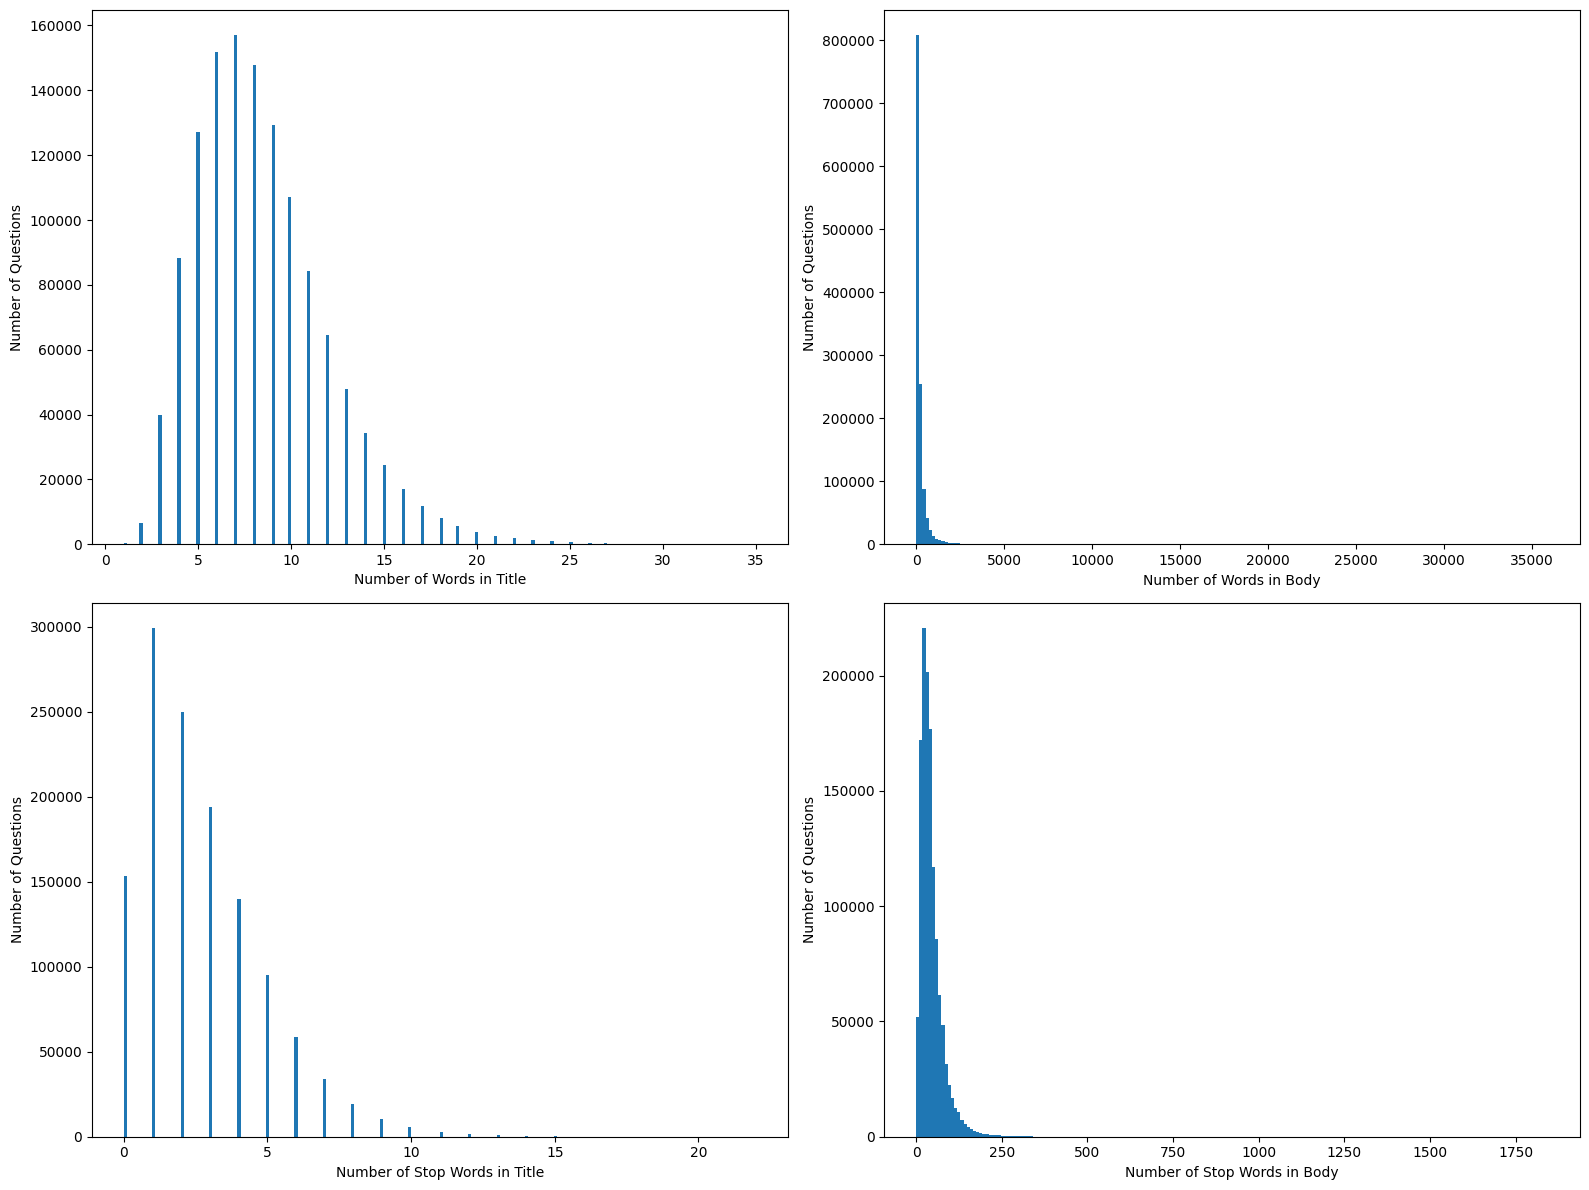

Title mean words count: 8.462
Title median words count: 8.000

Body mean words count: 245.940
Body median words count: 128.000

Title mean stop words count: 2.669
Title median stop words count: 2.000

Body mean stop words count: 44.556
Body median stop words count: 36.000


In [24]:
# preparing stop words
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('omw-1.4')

stop_words = set(stopwords.words('english'))

modified_qustions_df['NumberOfTitleWords'] = modified_qustions_df['Title'].apply(lambda x: len(str(x).split(" ")))
modified_qustions_df['NumberOfBodyWords'] = modified_qustions_df['Body'].apply(lambda x: len(str(x).split(" ")))

modified_qustions_df['NumberOfTitleStopWords'] = modified_qustions_df['Title'].apply(lambda x: len([word for word in x.split() if word.lower() in stop_words]))
modified_qustions_df['NumberOfBodyStopWords'] = modified_qustions_df['Body'].apply(lambda x: len([word for word in x.split() if word.lower() in stop_words]))

# plotting the distribution of NumberOfTitleWords and NumberOfBodyWords and NumberOfTitleStopWords and NumberOfBodyStopWords
plt.figure(figsize=(16, 12))

plt.subplot(2, 2, 1)
plt.hist(modified_qustions_df['NumberOfTitleWords'], bins=200)
plt.xlabel('Number of Words in Title')
plt.ylabel('Number of Questions')

plt.subplot(2, 2, 2)
plt.hist(modified_qustions_df['NumberOfBodyWords'], bins=200)
plt.xlabel('Number of Words in Body')
plt.ylabel('Number of Questions')

plt.subplot(2, 2, 3)
plt.hist(modified_qustions_df['NumberOfTitleStopWords'], bins=200)
plt.xlabel('Number of Stop Words in Title')
plt.ylabel('Number of Questions')

plt.subplot(2, 2, 4)
plt.hist(modified_qustions_df['NumberOfBodyStopWords'], bins=200)
plt.xlabel('Number of Stop Words in Body')
plt.ylabel('Number of Questions')

plt.tight_layout()
plt.savefig(data_analysis_path + 'title_body_words_distribution.png', dpi=300)
plt.show()

# printing the mean and median of NumberOfTitleWords and NumberOfBodyWords and NumberOfTitleStopWords and NumberOfBodyStopWords 
print('Title mean words count: {:.3f}'.format(modified_qustions_df['NumberOfTitleWords'].mean()))
print('Title median words count: {}'.format(modified_qustions_df['NumberOfTitleWords'].median()))
print('')
print('Body mean words count: {:.3f}'.format(modified_qustions_df['NumberOfBodyWords'].mean()))
print('Body median words count: {}'.format(modified_qustions_df['NumberOfBodyWords'].median()))
print('')
print('Title mean stop words count: {:.3f}'.format(modified_qustions_df['NumberOfTitleStopWords'].mean()))
print('Title median stop words count: {}'.format(modified_qustions_df['NumberOfTitleStopWords'].median()))
print('')
print('Body mean stop words count: {:.3f}'.format(modified_qustions_df['NumberOfBodyStopWords'].mean()))
print('Body median stop words count: {}'.format(modified_qustions_df['NumberOfBodyStopWords'].median()))

### Statistics on the number of special characters in titles and bodies of questions

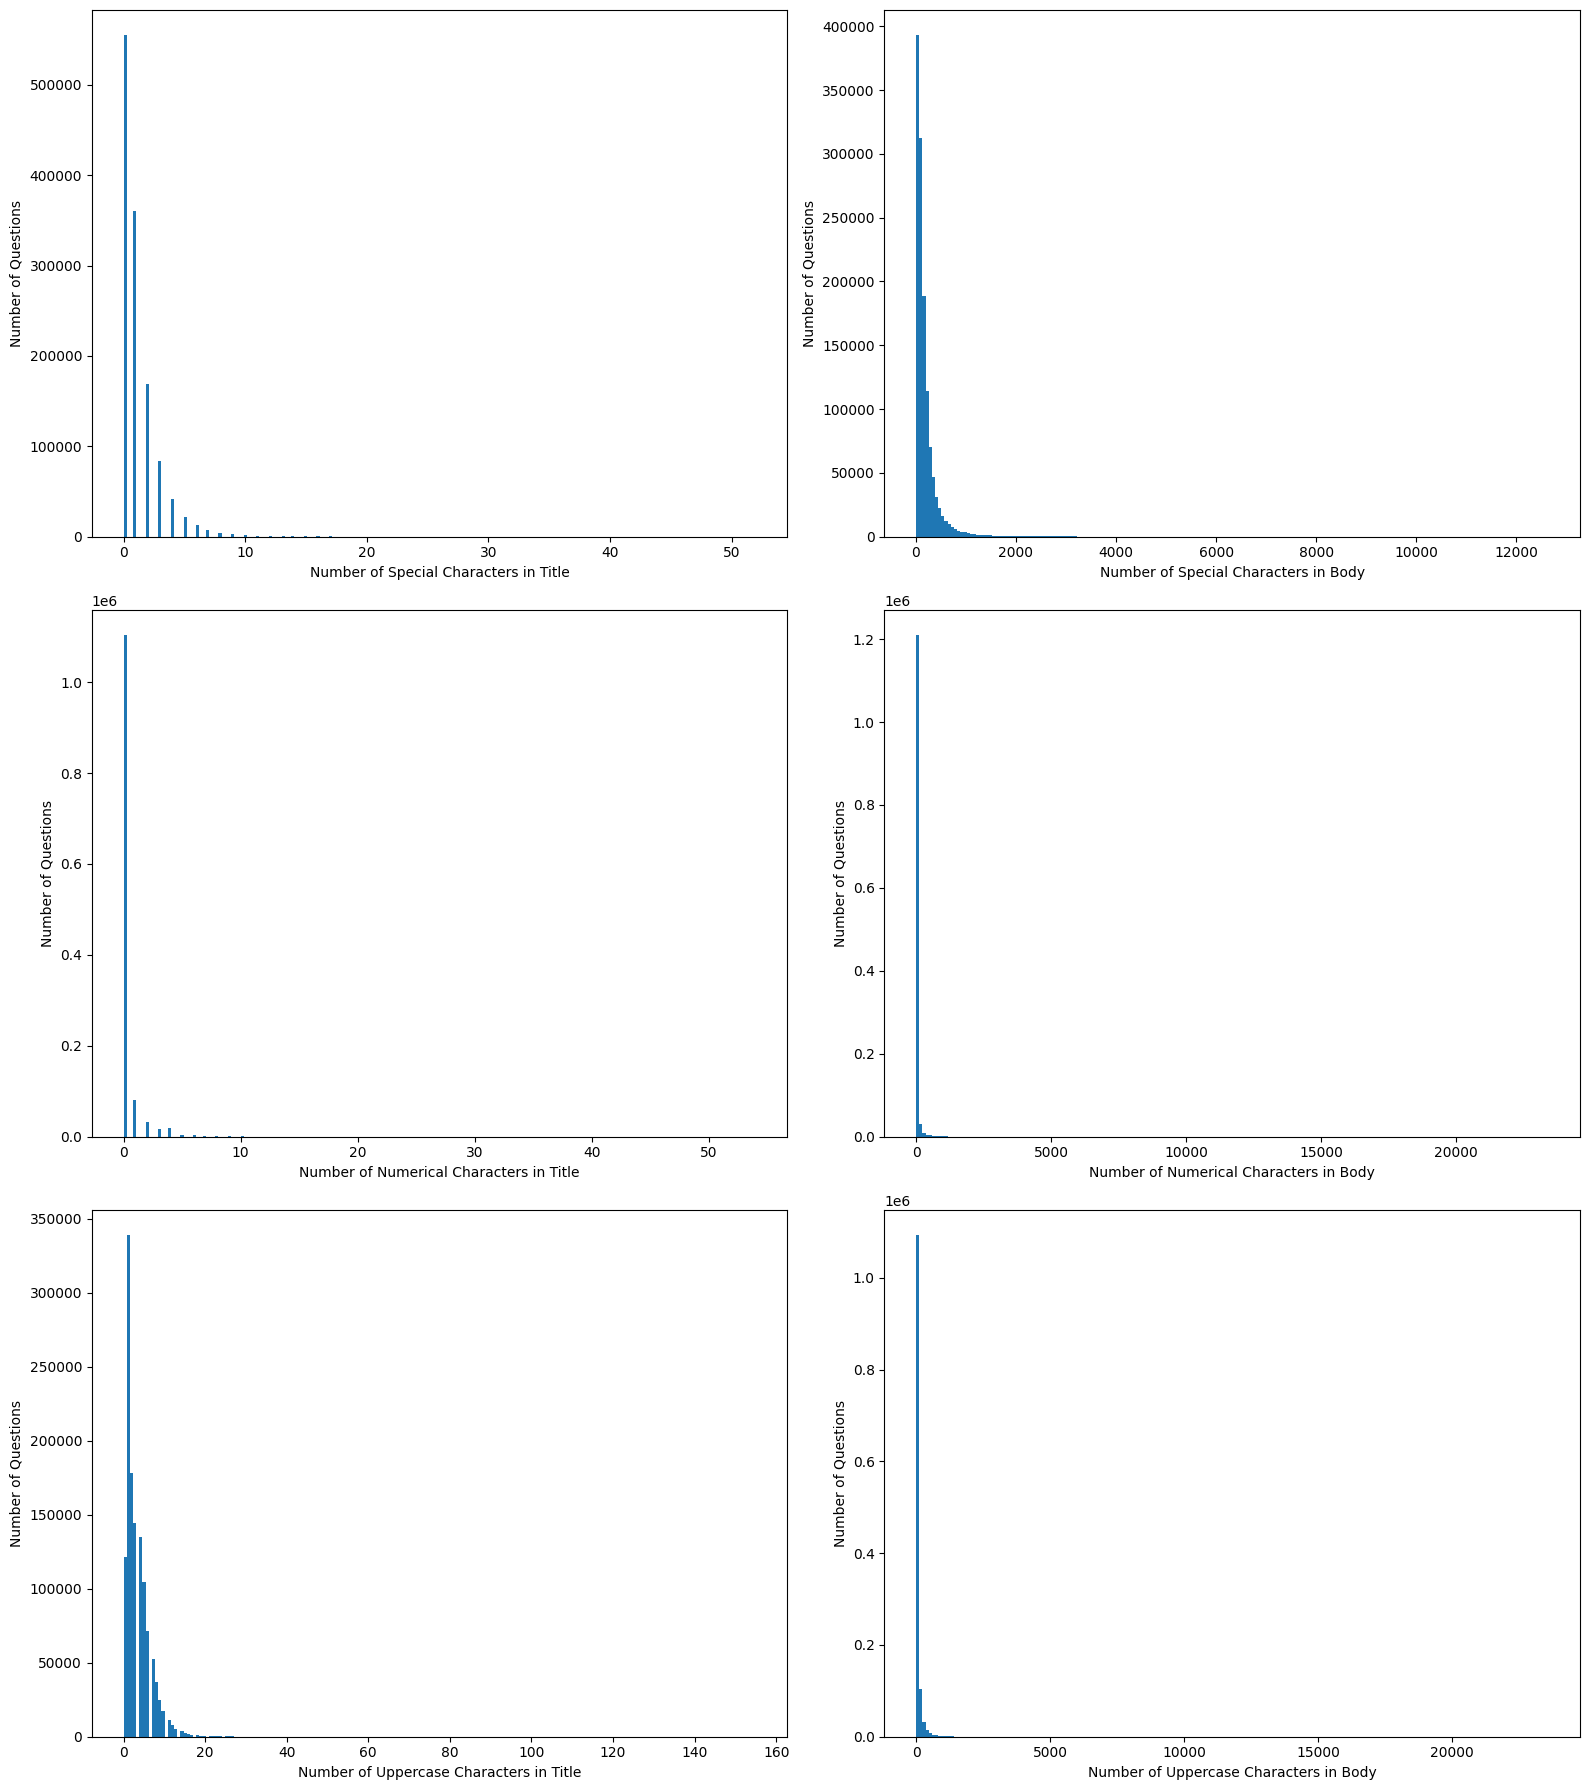

Title mean special characters count: 1.173
Title median special characters count: 1.000

Body mean special characters count: 188.693
Body median special characters count: 111.000

Title mean numerical characters count: 0.280
Title median numerical characters count: 0.000

Body mean numerical characters count: 29.612
Body median numerical characters count: 6.000

Title mean uppercase characters count: 3.344
Title median uppercase characters count: 2.000

Body mean uppercase characters count: 68.406
Body median uppercase characters count: 29.000


In [25]:
# calculating the number special characters in Title and Body
list_of_special_characters = ['!', '@', '#', '$', '%', '^', '&', '*', '(', ')', '_', '-', '+', '=', '{', '}', '[', ']', '|', '\\', ':', ';', '"', "'", '<', '>', ',', '.', '?', '/', '~', '`']
modified_qustions_df['NumberOfTitleSpecialCharacters'] = modified_qustions_df['Title'].apply(lambda x: len([char for char in str(x) if char in list_of_special_characters]))
modified_qustions_df['NumberOfBodySpecialCharacters'] = modified_qustions_df['Body'].apply(lambda x: len([char for char in str(x) if char in list_of_special_characters]))

# calculating the number of numerical characters in Title and Body
modified_qustions_df['NumberOfTitleNumericalCharacters'] = modified_qustions_df['Title'].apply(lambda x: len([char for char in str(x) if char.isnumeric()]))
modified_qustions_df['NumberOfBodyNumericalCharacters'] = modified_qustions_df['Body'].apply(lambda x: len([char for char in str(x) if char.isnumeric()]))

# calculating the number of uppercase characters in Title and Body
modified_qustions_df['NumberOfTitleUpperCaseCharacters'] = modified_qustions_df['Title'].apply(lambda x: len([char for char in str(x) if char.isupper()]))
modified_qustions_df['NumberOfBodyUpperCaseCharacters'] = modified_qustions_df['Body'].apply(lambda x: len([char for char in str(x) if char.isupper()]))

# plotting the distribution
plt.figure(figsize=(16, 18))

plt.subplot(3, 2, 1)
plt.hist(modified_qustions_df['NumberOfTitleSpecialCharacters'], bins=200)
plt.xlabel('Number of Special Characters in Title')
plt.ylabel('Number of Questions')

plt.subplot(3, 2, 2)
plt.hist(modified_qustions_df['NumberOfBodySpecialCharacters'], bins=200)
plt.xlabel('Number of Special Characters in Body')
plt.ylabel('Number of Questions')

plt.subplot(3, 2, 3)
plt.hist(modified_qustions_df['NumberOfTitleNumericalCharacters'], bins=200)
plt.xlabel('Number of Numerical Characters in Title')
plt.ylabel('Number of Questions')

plt.subplot(3, 2, 4)
plt.hist(modified_qustions_df['NumberOfBodyNumericalCharacters'], bins=200)
plt.xlabel('Number of Numerical Characters in Body')
plt.ylabel('Number of Questions')

plt.subplot(3, 2, 5)
plt.hist(modified_qustions_df['NumberOfTitleUpperCaseCharacters'], bins=200)
plt.xlabel('Number of Uppercase Characters in Title')
plt.ylabel('Number of Questions')

plt.subplot(3, 2, 6)
plt.hist(modified_qustions_df['NumberOfBodyUpperCaseCharacters'], bins=200)
plt.xlabel('Number of Uppercase Characters in Body')
plt.ylabel('Number of Questions')

plt.tight_layout()
plt.savefig(data_analysis_path + 'title_body_special_numerical_uppercase_characters_distribution.png', dpi=300)
plt.show()

# printing the mean and median values
print('Title mean special characters count: {:.3f}'.format(modified_qustions_df['NumberOfTitleSpecialCharacters'].mean()))
print('Title median special characters count: {}'.format(modified_qustions_df['NumberOfTitleSpecialCharacters'].median()))
print('')
print('Body mean special characters count: {:.3f}'.format(modified_qustions_df['NumberOfBodySpecialCharacters'].mean()))
print('Body median special characters count: {}'.format(modified_qustions_df['NumberOfBodySpecialCharacters'].median()))
print('')
print('Title mean numerical characters count: {:.3f}'.format(modified_qustions_df['NumberOfTitleNumericalCharacters'].mean()))
print('Title median numerical characters count: {}'.format(modified_qustions_df['NumberOfTitleNumericalCharacters'].median()))
print('')
print('Body mean numerical characters count: {:.3f}'.format(modified_qustions_df['NumberOfBodyNumericalCharacters'].mean()))
print('Body median numerical characters count: {}'.format(modified_qustions_df['NumberOfBodyNumericalCharacters'].median()))
print('')
print('Title mean uppercase characters count: {:.3f}'.format(modified_qustions_df['NumberOfTitleUpperCaseCharacters'].mean()))
print('Title median uppercase characters count: {}'.format(modified_qustions_df['NumberOfTitleUpperCaseCharacters'].median()))
print('')
print('Body mean uppercase characters count: {:.3f}'.format(modified_qustions_df['NumberOfBodyUpperCaseCharacters'].mean()))
print('Body median uppercase characters count: {}'.format(modified_qustions_df['NumberOfBodyUpperCaseCharacters'].median()))

### List of most common words in questions title and body

In [28]:
MostFreqWordsTitle = pd.Series(' '.join(modified_qustions_df['Title']).split()).value_counts()[:20]
MostFreqWordsBody = pd.Series(' '.join(modified_qustions_df['Body']).split()).value_counts()[:20]
# its probably better to remove the stop words before calculating the most frequent words

print('Most frequent words in Title: \n', MostFreqWordsTitle)
print('')
print('Most frequent words in Body: \n', MostFreqWordsBody)

Most frequent words in Title: 
 to       414051
in       360986
a        272887
How      192367
the      165502
with     145372
of       140804
and      125869
on       105392
from     104836
for       95070
not       91633
is        76482
using     76340
-         68607
I         68354
an        58291
when      49073
file      44627
how       38592
Name: count, dtype: int64

Most frequent words in Body: 
 the              6354821
to               4438333
=                3504554
I                3177780
a                2936070
is               2342820
{                2197637
and              2143157
in               2105260
}                2014353
of               1707050
</code></pre>    1619054
it               1268344
that             1251397
for              1184302
have             1129669
<p>I             1127781
this             1088486
my                934529
with              931853
Name: count, dtype: int64


### List of rare words in questions title and body

In [ ]:
RareWordsTitle = pd.Series(' '.join(modified_qustions_df['Title']).split()).value_counts()[-20:]
RareWordsBody = pd.Series(' '.join(modified_qustions_df['Body']).split()).value_counts()[-20:]
# its probably better to remove the stop words before calculating the rare words

print('Rare words in Title: \n', RareWordsTitle)
print('')
print('Rare words in Body: \n', RareWordsBody)

### Statistics of score

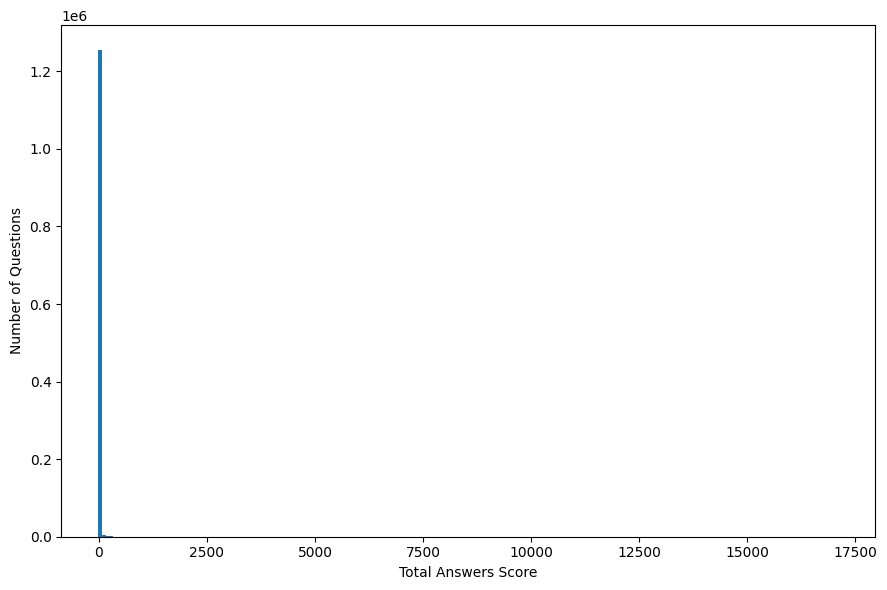

Total Answers Score mean: 3.953
Total Answers Score median: 1.0
Total Answers Score max: 17099.0
Total Answers Score min: -16.0


In [29]:
plt.figure(figsize=(9, 6))
plt.hist(modified_qustions_df['TotalAnswersScore'], bins=200)
plt.xlabel('Total Answers Score')
plt.ylabel('Number of Questions')

plt.tight_layout()
plt.savefig(data_analysis_path + 'total_answers_score_distribution.png', dpi=300)
plt.show()

# printing the mean, media, max and min values
print('Total Answers Score mean: {:.3f}'.format(modified_qustions_df['TotalAnswersScore'].mean()))
print('Total Answers Score median: {}'.format(modified_qustions_df['TotalAnswersScore'].median()))
print('Total Answers Score max: {}'.format(modified_qustions_df['TotalAnswersScore'].max()))
print('Total Answers Score min: {}'.format(modified_qustions_df['TotalAnswersScore'].min()))

### Correlation matrix

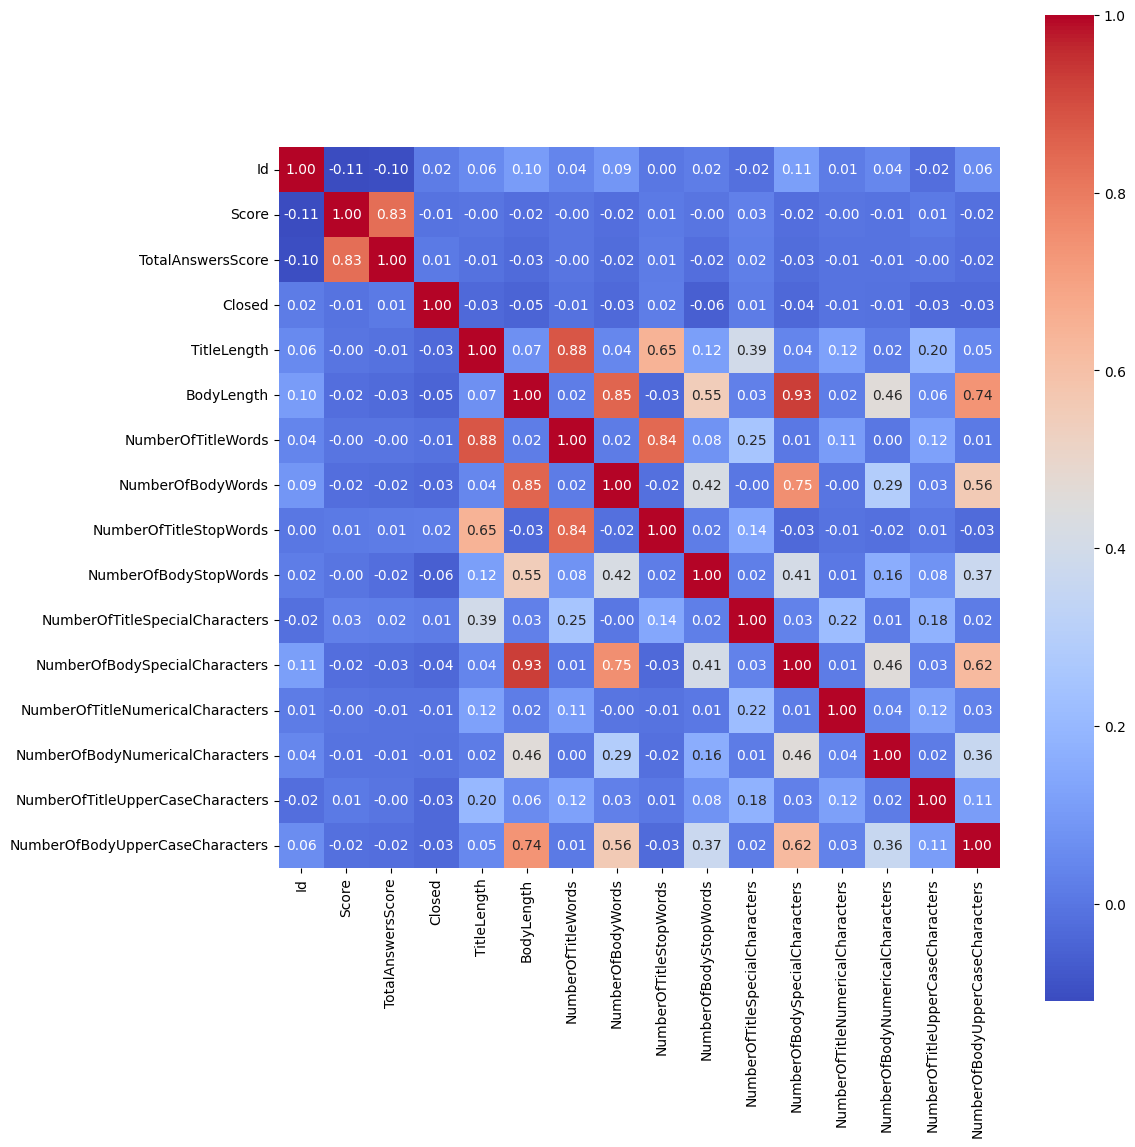

In [35]:
import seaborn as sns

# generate correlation matrix
correlation_matrix = modified_qustions_df.corr(numeric_only=True)

# plot the heatmap
plt.figure(figsize=(12, 12))
sns.heatmap(data=correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.gca().set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.savefig(data_analysis_path + 'correlation_matrix.png', dpi=300)
plt.show()